In [ ]:
!wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz
!tar -xvf /content/maps.tar.gz

--2024-03-20 06:35:40--  http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 250242400 (239M) [application/x-gzip]
Saving to: ‘maps.tar.gz’

maps.tar.gz         100%[===================>] 238.65M  1.39MB/s    in 2m 55s  

2024-03-20 06:38:35 (1.36 MB/s) - ‘maps.tar.gz’ saved [250242400/250242400]

maps/
maps/train/
maps/train/1.jpg
maps/train/10.jpg
maps/train/100.jpg
maps/train/1000.jpg
maps/train/1001.jpg
maps/train/1002.jpg
maps/train/1003.jpg
maps/train/1004.jpg
maps/train/1005.jpg
maps/train/1006.jpg
maps/train/1007.jpg
maps/train/1008.jpg
maps/train/1009.jpg
maps/train/101.jpg
maps/train/1010.jpg
maps/train/1011.jpg
maps/train/1012.jpg
maps/train/1013.jpg
maps/train/1014.jpg
maps/train/1015.jpg
maps/train/530.jpg
maps/train/53

In [ ]:

# load, split and scale the maps dataset ready for training
from os import listdir
from numpy import asarray
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed

# load all images in a directory into memory
def load_images(path, size=(256,512)):
 src_list, tar_list = list(), list()
 # enumerate filenames in directory, assume all are images
 for filename in listdir(path):
 # load and resize the image
   pixels = load_img(path + filename, target_size=size)
 # convert to numpy array
   pixels = img_to_array(pixels)
 # split into satellite and map
   sat_img, map_img = pixels[:, :256], pixels[:, 256:]
   src_list.append(sat_img)
   tar_list.append(map_img)
 return [asarray(src_list), asarray(tar_list)]

# dataset path
path = '/content/maps/train/'
# load dataset
[src_images, tar_images] = load_images(path)
print('Loaded: ', src_images.shape, tar_images.shape)
# save as compressed numpy array
filename = 'maps_256.npz'
savez_compressed(filename, src_images, tar_images)
print('Saved dataset: ', filename)

Loaded:  (1096, 256, 256, 3) (1096, 256, 256, 3)
Saved dataset:  maps_256.npz


In [ ]:
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, BatchNormalization, Concatenate, Activation
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

# weight initialization
init = RandomNormal(stddev=0.02)
# define the discriminator model
def get_discriminator(image_shape):

 # source image input
 in_src_image = Input(shape=image_shape)
 # target image input
 in_target_image = Input(shape=image_shape)
 # concatenate images channel-wise
 merged = Concatenate()([in_src_image, in_target_image])
 # C64
 d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
 d = LeakyReLU(alpha=0.2)(d)
 # C128
 d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
 d = BatchNormalization()(d)
 d = LeakyReLU(alpha=0.2)(d)
 # C256
 d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
 d = BatchNormalization()(d)
 d = LeakyReLU(alpha=0.2)(d)
 # C512
 d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
 d = BatchNormalization()(d)
 d = LeakyReLU(alpha=0.2)(d)
 # second last output layer
 d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
 d = BatchNormalization()(d)
 d = LeakyReLU(alpha=0.2)(d)
 # patch output
 d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
 patch_out = Activation('sigmoid')(d)
 # define model
 model = Model([in_src_image, in_target_image], patch_out)
 # compile model
 opt = Adam(learning_rate=0.0002, beta_1=0.5)
 model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
 return model

Loaded:  (1096, 256, 256, 3) (1096, 256, 256, 3)


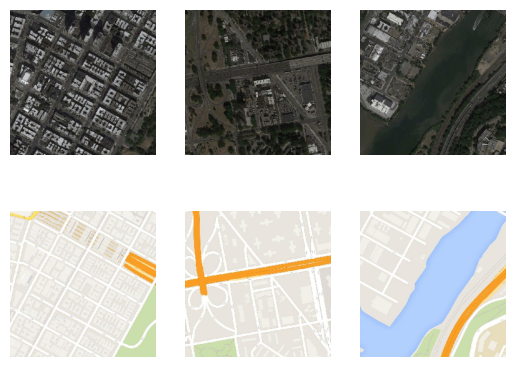

In [ ]:
# load the prepared dataset
from numpy import load
from matplotlib import pyplot
# load the dataset
data = load('maps_256.npz')
src_images, tar_images = data['arr_0'], data['arr_1']
print('Loaded: ', src_images.shape, tar_images.shape)
# plot source images
n_samples = 3
for i in range(n_samples):
 pyplot.subplot(2, n_samples, 1 + i)
 pyplot.axis('off')
 pyplot.imshow(src_images[i].astype('uint8'))
# plot target image
for i in range(n_samples):
 pyplot.subplot(2, n_samples, 1 + n_samples + i)
 pyplot.axis('off')
 pyplot.imshow(tar_images[i].astype('uint8'))
pyplot.show()

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, BatchNormalization, Concatenate, Activation
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

# weight initialization
init = RandomNormal(stddev=0.02)
# define the discriminator model
def get_discriminator(image_shape):

 # source image input
 in_src_image = Input(shape=image_shape)
 # target image input
 in_target_image = Input(shape=image_shape)
 # concatenate images channel-wise
 merged = Concatenate()([in_src_image, in_target_image])
 # C64
 d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
 d = LeakyReLU(alpha=0.2)(d)
 # C128
 d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
 d = BatchNormalization()(d)
 d = LeakyReLU(alpha=0.2)(d)
 # C256
 d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
 d = BatchNormalization()(d)
 d = LeakyReLU(alpha=0.2)(d)
 # C512
 d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
 d = BatchNormalization()(d)
 d = LeakyReLU(alpha=0.2)(d)
 # second last output layer
 d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
 d = BatchNormalization()(d)
 d = LeakyReLU(alpha=0.2)(d)
 # patch output
 d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
 patch_out = Activation('sigmoid')(d)
 # define model
 model = Model([in_src_image, in_target_image], patch_out)
 # compile model
 opt = Adam(learning_rate=0.0002, beta_1=0.5)
 model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
 return model

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


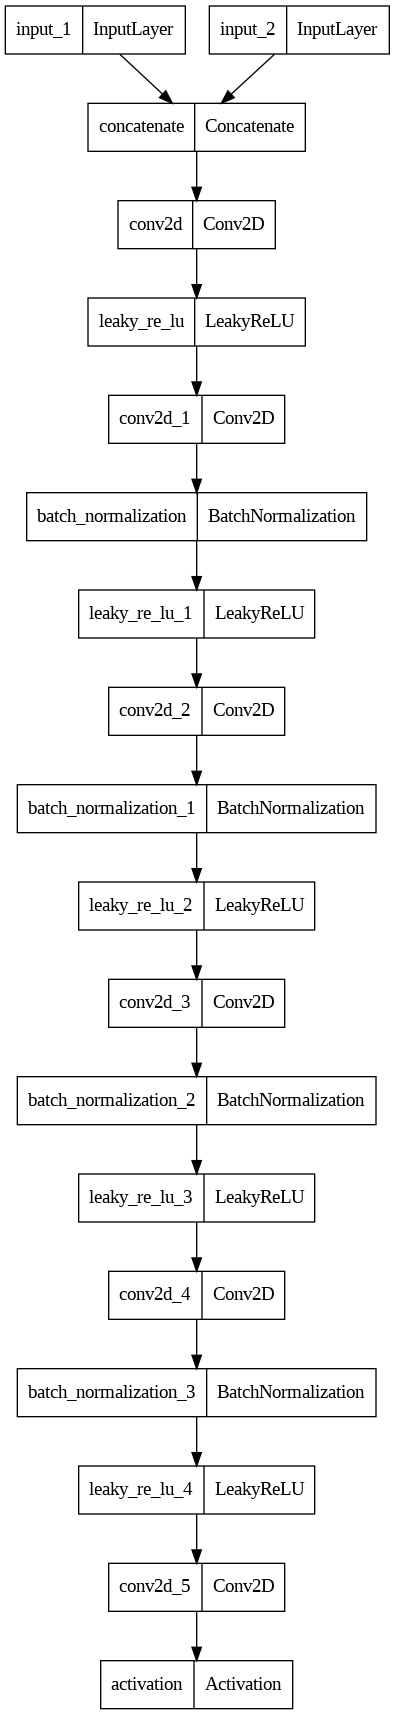

In [ ]:
from tensorflow.keras.utils import plot_model
discriminator = get_discriminator((256, 256, 3))
plot_model(discriminator)

In [ ]:
from tensorflow.keras.layers import Conv2DTranspose, BatchNormalization, Dropout, Concatenate, Activation
from tensorflow.keras.initializers import RandomNormal
def encoder_block(layer_in, n_filters, batchnorm=True):
 g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
 # conditionally add batch normalization
 if batchnorm:
    g = BatchNormalization()(g, training=True)
 # leaky relu activation
 g = LeakyReLU(alpha=0.2)(g)
 return g

# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
 g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
 # add batch normalization
 g = BatchNormalization()(g, training=True)
 # conditionally add dropout
 if dropout:
   g = Dropout(0.5)(g, training=True)
 # merge with skip connection
 g = Concatenate()([g, skip_in])
 # relu activation
 g = Activation('relu')(g)
 return g

In [ ]:
def get_generator(image_shape=(256,256,3)):


 in_image = Input(shape=image_shape)
 # encoder model
 e1 = encoder_block(in_image, 64, batchnorm=False)
 e2 = encoder_block(e1, 128)
 e3 = encoder_block(e2, 256)
 e4 = encoder_block(e3, 512)
 e5 = encoder_block(e4, 512)
 e6 = encoder_block(e5, 512)
 e7 = encoder_block(e6, 512)
 # bottleneck, no batch norm and relu
 b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
 b = Activation('relu')(b)
 # decoder model
 d1 = decoder_block(b, e7, 512)
 d2 = decoder_block(d1, e6, 512)
 d3 = decoder_block(d2, e5, 512)
 d4 = decoder_block(d3, e4, 512, dropout=False)
 d5 = decoder_block(d4, e3, 256, dropout=False)
 d6 = decoder_block(d5, e2, 128, dropout=False)
 d7 = decoder_block(d6, e1, 64, dropout=False)
 # output
 g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
 out_image = Activation('tanh')(g)
 # define model
 model = Model(in_image, out_image)
 return model

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def get_gan(g_model, d_model, image_shape):

 for layer in d_model.layers:
    if not isinstance(layer, BatchNormalization):
       layer.trainable = False

 in_src = Input(shape=image_shape)
 # connect the source image to the generator input
 gen_out = g_model(in_src)
 # connect the source input and generator output to the discriminator input
 dis_out = d_model([in_src, gen_out])
 # src image as input, generated image and classification output
 model = Model(in_src, [dis_out, gen_out])
 # compile model
 opt = Adam(learning_rate=0.0002, beta_1=0.5)
 model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
 return model



In [ ]:
import numpy as np
from numpy import ones

import random
def load_real_samples(filename):
 # load compressed arrays
 data = load(filename)
 # unpack arrays
 X1, X2 = data['arr_0'], data['arr_1']
 # scale from [0,255] to [-1,1]
 X1 = (X1 - 127.5) / 127.5
 X2 = (X2 - 127.5) / 127.5
 return [X1, X2]

# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
 # unpack dataset
 trainA, trainB = dataset
 # choose random instances

 ix = random.sample(range(trainA.shape[0]), n_samples)
 # retrieve selected images
 X1, X2 = trainA[ix], trainB[ix]
 # generate 'real' class labels (1)
 y = ones((n_samples, patch_shape, patch_shape, 1))
 return [X1, X2], y

In [ ]:
from numpy import zeros
def generate_fake_samples(g_model, samples, patch_shape):
 # generate fake instance
 X = g_model.predict(samples)
 # create 'fake' class labels (0)
 y = zeros((len(X), patch_shape, patch_shape, 1))
 return X, y

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, dataset, n_samples=3):
 # select a sample of input images
 [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
 # generate a batch of fake samples
 X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
 # scale all pixels from [-1,1] to [0,1]
 X_realA = (X_realA + 1) / 2.0
 X_realB = (X_realB + 1) / 2.0
 X_fakeB = (X_fakeB + 1) / 2.0
 # plot real source images
 for i in range(n_samples):
   pyplot.subplot(3, n_samples, 1 + i)
   pyplot.axis('off')
   pyplot.imshow(X_realA[i])
 # plot generated target image
 for i in range(n_samples):
   pyplot.subplot(3, n_samples, 1 + n_samples + i)
   pyplot.axis('off')
   pyplot.imshow(X_fakeB[i])
 # plot real target image
 for i in range(n_samples):
   pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
   pyplot.axis('off')
   pyplot.imshow(X_realB[i])
 # save plot to file
 filename1 = 'plot_%06d.png' % (step+1)
 pyplot.savefig(filename1)
 pyplot.show()
 # save the generator model
 filename2 = 'model_%06d.h5' % (step+1)
 g_model.save(filename2)
 print('>Saved: %s and %s' % (filename1, filename2))

In [ ]:
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
 # determine the output square shape of the discriminator
 n_patch = d_model.output_shape[1]
 # unpack dataset
 trainA, trainB = dataset
 # calculate the number of batches per training epoch
 bat_per_epo = int(len(trainA) / n_batch)
 # calculate the number of training iterations
 n_steps = bat_per_epo * n_epochs
 # manually enumerate epochs
 for i in range(n_steps):
 # select a batch of real samples
   [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
 # generate a batch of fake samples
   X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
 # update discriminator for real samples
   d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
 # update discriminator for generated samples
   d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
 # update the generator
   g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
 # summarize performance
   print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
 # summarize model performance
 if (i) % (bat_per_epo * 10) == 0:
   summarize_performance(i, g_model, dataset)

In [ ]:

# load image data
dataset = load_real_samples('maps_256.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# define the models
d_model = get_discriminator(image_shape)
g_model = get_generator(image_shape)
# define the composite model
gan_model = get_gan(g_model, d_model, image_shape)
# train model
train(d_model, g_model, gan_model, dataset)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 24ms/step
>8699, d1[0.514] d2[0.200] g[8.888]
1/1 [==============================] - 0s 26ms/step
>8700, d1[0.017] d2[0.204] g[8.530]
1/1 [==============================] - 0s 28ms/step
>8701, d1[0.171] d2[0.238] g[8.208]
1/1 [==============================] - 0s 25ms/step
>8702, d1[0.189] d2[0.380] g[9.302]
1/1 [==============================] - 0s 27ms/step
>8703, d1[0.108] d2[0.098] g[8.022]
1/1 [==============================] - 0s 25ms/step
>8704, d1[0.730] d2[0.117] g[6.985]
1/1 [==============================] - 0s 31ms/step
>8705, d1[0.010] d2[0.179] g[10.014]
1/1 [==============================] - 0s 25ms/step
>8706, d1[0.097] d2[0.206] g[7.653]
1/1 [==============================] - 0s 25ms/step
>8707, d1[0.012] d2[0.060] g[6.836]
1/1 [==============================] - 0s 38ms/step
>8708, d1[0.218] d2[0.192] g[8.780]
1/1 [==============================] - 0s 34ms/step
>8709, d1[0.016]

KeyboardInterrupt: 

1/1 [==============================] - 0s 23ms/step


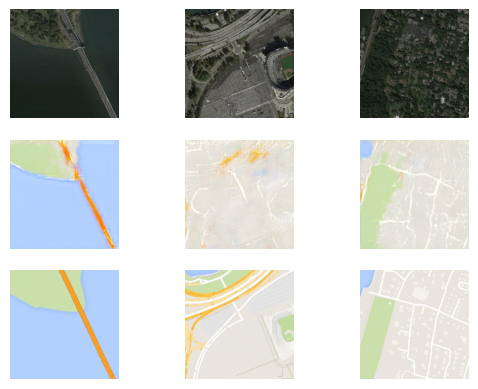

>Saved: plot_000011.png and model_000011.h5


In [ ]:
summarize_performance( 10, g_model, dataset)